In [1]:
import random
import time
import os
import glob 
import networkx as nx
import numpy as np
from copy import deepcopy
from tabulate import tabulate
from matplotlib import pyplot as plt

RESULTS_PATH = "resultsGA"

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

# Omogućava prikaz grafikona unutar Notebook-a
%matplotlib inline

In [2]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        if degree > maxDegree:
            maxDegree = degree
    return maxDegree

def readGraph(filePath):
    graph = nx.Graph()
    with open(filePath) as f:
        lines = f.readlines()

        #.txt fajl, da ne pukne osiguravamo se zbog pocetka sa p
        pLine = [l for l in lines if l.startswith('p')]
        if pLine:
            numNodes = int(pLine[0].split()[2])
        else:
            numNodes = int(lines[0].split()[2])
        

        #numNodes = int(lines[0].split()[2])
        # Normalizacija grana: sorted osigurava da je (1,2) isto što i (2,1)
        rawEdges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        edges = [tuple(sorted(edge)) for edge in rawEdges]
        graph.add_nodes_from(range(1, numNodes + 1))
        graph.add_edges_from(edges)
    return graph

def getFitness(chromosome, edges, maxNode):
    conflicts = 0
    nodeMap = {i: [] for i in range(1, maxNode + 1)}
    for i, color in enumerate(chromosome):
        u, v = edges[i]
        nodeMap[u].append(color)
        nodeMap[v].append(color)
    for node in nodeMap:
        colors = nodeMap[node]
        if len(colors) > 1:
            conflicts += (len(colors) - len(set(colors)))
    return conflicts

In [3]:
def selectionTournament(population, fitnesses, k=3):
    participants = random.sample(list(zip(population, fitnesses)), k)
    return min(participants, key=lambda x: x[1])[0]

def selectionRoulette(population, fitnesses):
    # Što manji fitnes, to veća šansa (proporcionalno 1/f)
    invertedFitness = [1.0 / (f + 1e-6) for f in fitnesses]
    total = sum(invertedFitness)
    pick = random.uniform(0, total)
    current = 0
    for i, f in enumerate(invertedFitness):
        current += f
        if current > pick:
            return population[i]
    return population[0]

def selectionRank(population, fitnesses):
    popSize = len(population)
    sortedIndices = np.argsort(fitnesses)[::-1] 
    ranks = np.empty(popSize)
    for rank, idx in enumerate(range(popSize)):
        ranks[sortedIndices[idx]] = rank + 1
    totalRank = sum(ranks)
    pick = random.uniform(0, totalRank)
    current = 0
    for i in range(popSize):
        current += ranks[i]
        if current > pick: return population[i]
    return population[0]

In [4]:
def crossoverUniform(p1, p2):
    return [p1[i] if random.random() < 0.5 else p2[i] for i in range(len(p1))]

def crossoverSinglePoint(p1, p2):
    point = random.randint(1, len(p1) - 1)
    return p1[:point] + p2[point:]

def crossoverTwoPoint(p1, p2):
    size = len(p1)
    if size < 3: return crossoverSinglePoint(p1, p2)
    pt1 = random.randint(1, size - 2)
    pt2 = random.randint(pt1 + 1, size - 1)
    return p1[:pt1] + p2[pt1:pt2] + p1[pt2:]

In [5]:
def mutationSmart(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    u, v = edges[idx]
    forbidden = set()
    for i, (n1, n2) in enumerate(edges):
        if i != idx and (n1 in (u, v) or n2 in (u, v)):
            forbidden.add(chromosome[i])
    available = list(set(range(1, delta + 2)) - forbidden)
    if available:
        chromosome[idx] = random.choice(available)
    else:
        chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationRandom(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationSwap(chromosome, edges, maxNode, delta):
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

In [6]:
# def runGaModular(graph, maxIters, popSize, selFunc, crossFunc, mutFunc):
#     edges = list(graph.edges())
#     if not edges: return [], 0, []
#     maxNode, delta, numEdges = max(graph.nodes()), maxNumOfColours(graph), len(edges)
#     population = [[random.randint(1, delta + 1) for _ in range(numEdges)] for _ in range(popSize)]
    
#     history = [] # Za grafikon konvergencije
    
#     for gen in range(maxIters):
#         fitnesses = [getFitness(c, edges, maxNode) for c in population]
#         bestFit = min(fitnesses)
#         history.append(bestFit)
        
#         if bestFit == 0:
#             history.extend([0] * (maxIters - len(history)))
#             break
            
#         popWithFit = sorted(zip(population, fitnesses), key=lambda x: x[1])
#         newPop = [popWithFit[0][0], popWithFit[1][0]] # Elitizam
        
#         while len(newPop) < popSize:
#             p1, p2 = selFunc(population, fitnesses), selFunc(population, fitnesses)
#             child = crossFunc(p1, p2)
#             if random.random() < 0.3:
#                 child = mutFunc(child, edges, maxNode, delta)
#             newPop.append(child)
#         population = newPop
        
#     finalFits = [getFitness(c, edges, maxNode) for c in population]
#     bestIdx = np.argmin(finalFits)
#     return population[bestIdx], finalFits[bestIdx], history
def runGaModular(graph, maxIters, popSize, selFunc, crossFunc, mutFunc, numColours):
    edges = list(graph.edges())
    if not edges: return [], 0, []
    maxNode, numEdges = max(graph.nodes()), len(edges)
    population = [[random.randint(1, numColours) for _ in range(numEdges)] for _ in range(popSize)]
    history = []
    for gen in range(maxIters):
        fitnesses = [getFitness(c, edges, maxNode) for c in population]
        bestFit = min(fitnesses)
        history.append(bestFit)
        if bestFit == 0:
            history.extend([0] * (maxIters - len(history)))
            break
        popWithFit = sorted(zip(population, fitnesses), key=lambda x: x[1])
        newPop = [popWithFit[0][0], popWithFit[1][0]]
        while len(newPop) < popSize:
            p1, p2 = selFunc(population, fitnesses), selFunc(population, fitnesses)
            child = crossFunc(p1, p2)
            if random.random() < 0.3:
                child = mutFunc(child, edges, maxNode, numColours)
            newPop.append(child)
        population = newPop
    finalFits = [getFitness(c, edges, maxNode) for c in population]
    bestIdx = np.argmin(finalFits)
    return population[bestIdx], finalFits[bestIdx], history

In [7]:
# def processAndVisualize(filePath):
#     graph = readGraph(filePath)
#     fileName = os.path.basename(filePath)
#     delta = maxNumOfColours(graph)
    
#     selections = [selectionTournament, selectionRoulette, selectionRank]
#     crossovers = [crossoverSinglePoint, crossoverUniform, crossoverTwoPoint]
#     mutations = [mutationRandom, mutationSmart, mutationSwap]
    
#     allResults = []

#     print(f"\n>>> ANALYZING GRAPH: {fileName}")
#     for sel in selections:
#         for cross in crossovers:
#             for mut in mutations:
#                 sName = sel.__name__.replace('selection', '')
#                 cName = cross.__name__.replace('crossover', '')
#                 mName = mut.__name__.replace('mutation', '')
                
#                 t0 = time.perf_counter()
#                 sol, fit, hist = runGaModular(graph, 250, 40, sel, cross, mut)
#                 dt = time.perf_counter() - t0
                
#                 allResults.append({
#                     'selection': sName,
#                     'crossover': cName,
#                     'mutation': mName,
#                     'fit': fit,
#                     'time': dt,
#                     'hist': hist,
#                     'sol': sol
#                 })

#     allResults.sort(key=lambda x: (x['fit'], x['time']))
    
#     # odvojene kolone
#     fullTableData = []
    # for i, r in enumerate(allResults):
    #     fullTableData.append([
    #         i, 
    #         r['selection'], 
    #         r['crossover'], 
    #         r['mutation'], 
    #         r['fit'], 
    #         delta + 1, 
    #         f"{r['time']:.6f}"
    #     ])

    # headers = ["", "selection", "crossover", "mutation", "num of conf", "colours", "time"]

    # # 1. konzola: top 3
    # print(f"Top 3 Combinations for {fileName}:")
    # print(tabulate(fullTableData[:3], headers=headers, tablefmt="fancy_grid"))

    # # 2. fajl: svih 27
    # txtPath = os.path.join(RESULTS_PATH, fileName) 
    # with open(txtPath, 'w', encoding='utf-8') as f:
    #     f.write(f"Graph can be coloured with {delta} or {delta+1} colours. Class 1 or class 2 respectively.\n")
    #     f.write(tabulate(fullTableData, headers=headers, tablefmt="fancy_grid"))
    #     if allResults[0]['fit'] == 0:
    #         f.write(f"\nGraph is class 1, meaning chromatic index is equal to the graph's degree.")
    #     else:
    #         f.write(f"\nNo conflict-free colouring is found, therefore graph is classified as class 2.")

    # # 3. VIZUELIZACIJA
    # plt.figure(figsize=(16, 7))
    
    # # podplot 1: Obojeni graf
    # plt.subplot(1, 2, 1)
    # pos = nx.spring_layout(graph, seed=42)
    # nx.draw(graph, pos, edge_color=allResults[0]['sol'], width=2, with_labels=True, 
    #         node_color='lightblue', edge_cmap=plt.cm.rainbow)
    # plt.title(f"Winner (Rank 0):\n{allResults[0]['selection']} + {allResults[0]['crossover']} + {allResults[0]['mutation']}")

    # # podplot 2: Konvergencija
    # plt.subplot(1, 2, 2)
    # for i in range(min(3, len(allResults))):
    #     res = allResults[i]
    #     # ISPIS SVA TRI OPERATORA U LEGENDI:
    #     label_name = f"Rank {i}: {res['selection']} + {res['crossover']} + {res['mutation']}"
    #     plt.plot(res['hist'], label=label_name, linewidth=2.5)
    
    # # osa
    # plt.xlabel("Generations (Algorithm Progress)", fontsize=11)
    # plt.ylabel("Number of Conflicts (Fitness)", fontsize=11)
    # plt.title(f"Convergence Race: Top 3 Algorithms for {fileName}", fontsize=13)
    
    # # namestanje legende
    # plt.legend(loc='upper right', fontsize='small')
    # plt.grid(True, linestyle=':', alpha=0.8)
    
    # plt.tight_layout()
    # plt.show()

    # plt.close('all')#dodato naknadno

    # print(f"Full table (27 combinations) saved to: {txtPath}")
    
def processAndVisualize(filePath):
    graph = readGraph(filePath)
    fileName = os.path.basename(filePath)
    delta = maxNumOfColours(graph)
    if graph.number_of_edges() == 0: return

    
    f_lower = fileName.lower()
    type_info = "Unknown Graph Type"
    theory_note = ""
    is_bipartite = nx.is_bipartite(graph)
    if "completegraph" in f_lower or "k_" in f_lower:
        try:
            n = int(''.join(filter(str.isdigit, fileName)))
            type_info = f"Complete Graph K({n})"
            if n % 2 == 0: theory_note = f"Class 1 (Expected χ' = Δ = {n-1})"
            else: theory_note = f"Class 2 (Expected χ' = Δ + 1 = {n})"
        except: type_info = "Complete Graph"
    elif "bipartite" in f_lower or is_bipartite:
        type_info = "Bipartite Graph"
        theory_note = f"Always Class 1 (Expected χ' = Δ = {delta})"
    elif "petersen" in f_lower or "snark" in f_lower or "flower" in f_lower:
        type_info = "SNARK / Petersen Graph"
        theory_note = f"Class 2 (Expected χ' = Δ + 1 = {delta+1})"
    elif "regular" in f_lower:
        type_info = f"Random Regular Graph (d={delta})"
        theory_note = "Most are Class 1"
    elif "graph" in f_lower:
        type_info = "Random G(n,p) Graph"
        theory_note = "Vizing's Theorem: Class 1 or 2"

    print(f"\n>>> ANALYZING: {fileName}")
    print(f"[TYPE]: {type_info}")
    if theory_note: print(f"[THEORY]: {theory_note}")

    selections = [selectionTournament, selectionRoulette, selectionRank]
    crossovers = [crossoverSinglePoint, crossoverUniform, crossoverTwoPoint]
    mutations = [mutationRandom, mutationSmart, mutationSwap]

    
    def run_tests(num_cols):
        res_list = []
        for sel in selections:
            for cross in crossovers:
                for mut in mutations:
                    sName = sel.__name__.replace('selection', '')
                    cName = cross.__name__.replace('crossover', '')
                    mName = mut.__name__.replace('mutation', '')
                    t0 = time.perf_counter()
                    sol, fit, hist = runGaModular(graph, 500, 100, sel, cross, mut, num_cols)
                    dt = time.perf_counter() - t0
                    res_list.append({'selection': sName, 'crossover': cName, 'mutation': mName,
                                     'fit': fit, 'time': dt, 'hist': hist, 'sol': sol, 'cols': num_cols})
        return res_list

    # Prvi krug
    allResults = run_tests(delta)
    allResults.sort(key=lambda x: (x['fit'], x['time']))
    
    found_zero = allResults[0]['fit'] == 0
    secondAttemptResults = []

    if not found_zero:
        print(f"!!! Nema nule sa {delta} boja. Pokrećem Delta + 1 = {delta+1}...")
        secondAttemptResults = run_tests(delta + 1)
        secondAttemptResults.sort(key=lambda x: (x['fit'], x['time']))

    
    def prepare_table(results):
        data = []
        for i, r in enumerate(results):
            data.append([i, r['selection'], r['crossover'], r['mutation'], r['fit'], r['cols'], f"{r['time']:.6f}"])
        return data

    headers = ["Rank", "selection", "crossover", "mutation", "num of conf", "colours", "time"]
    
    # Konzola: Top 3
    print(f"Top 3 Combinations for {fileName}:")
    print(tabulate(prepare_table(allResults if found_zero else secondAttemptResults)[:3], headers=headers, tablefmt="fancy_grid"))

    # Fajl: format sa dopisivanjem rezultata
    txtPath = os.path.join(RESULTS_PATH, fileName) 
    with open(txtPath, 'w', encoding='utf-8') as f:
        f.write(f"Graph: {fileName} | Type: {type_info}\nTheory: {theory_note}\nMax Degree (Delta): {delta}\n\n")
        f.write("--- RESULTS FOR DELTA ---\n")
        f.write(tabulate(prepare_table(allResults), headers=headers, tablefmt="fancy_grid"))
        if secondAttemptResults:
            f.write("\n\n--- RESULTS FOR DELTA + 1 ---\n")
            f.write(tabulate(prepare_table(secondAttemptResults), headers=headers, tablefmt="fancy_grid"))
        
        if found_zero: f.write(f"\n\nRESULT: Class 1 found (Index = {delta})")
        elif secondAttemptResults and secondAttemptResults[0]['fit'] == 0: f.write(f"\n\nRESULT: Class 2 found (Index = {delta+1})")
        else: f.write(f"\n\nRESULT: GA failed to find 0 conflicts.")

    
    best = allResults[0] if found_zero or not secondAttemptResults else secondAttemptResults[0]
    plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, edge_color=best['sol'], width=2.5, with_labels=True, node_color='lightblue', edge_cmap=plt.cm.rainbow)
    plt.title(f"Winner (Rank 0):\n{best['selection']} + {best['crossover']} + {best['mutation']}")

    plt.subplot(1, 2, 2)
    plot_data = allResults[:3] if found_zero else secondAttemptResults[:3]
    for i, res in enumerate(plot_data):
        label_name = f"Rank {i}: {res['selection']} + {res['crossover']} + {res['mutation']}"
        plt.plot(res['hist'], label=label_name, linewidth=2.5)
    
    plt.xlabel("Generations (Algorithm Progress)", fontsize=11)
    plt.ylabel("Number of Conflicts (Fitness)", fontsize=11)
    plt.title(f"Convergence Race: Top 3 Algorithms for {fileName}", fontsize=13)
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.8)
    plt.tight_layout()
    plt.show()
    plt.close('all')
    print(f"Full table saved to: {txtPath}")
    


########################################
# ENTERING FOLDER: smallTests
########################################

>>> ANALYZING: graph11.txt
[TYPE]: Bipartite Graph
[THEORY]: Always Class 1 (Expected χ' = Δ = 3)
Top 3 Combinations for graph11.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Rank        │ TwoPoint    │ Smart      │             0 │         3 │ 0.001586 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Rank        │ TwoPoint    │ Random     │             0 │         3 │ 0.001875 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ TwoPoint    │ Random     │             0 │         3 │ 0.001935 │
╘════════╧═════════════╧

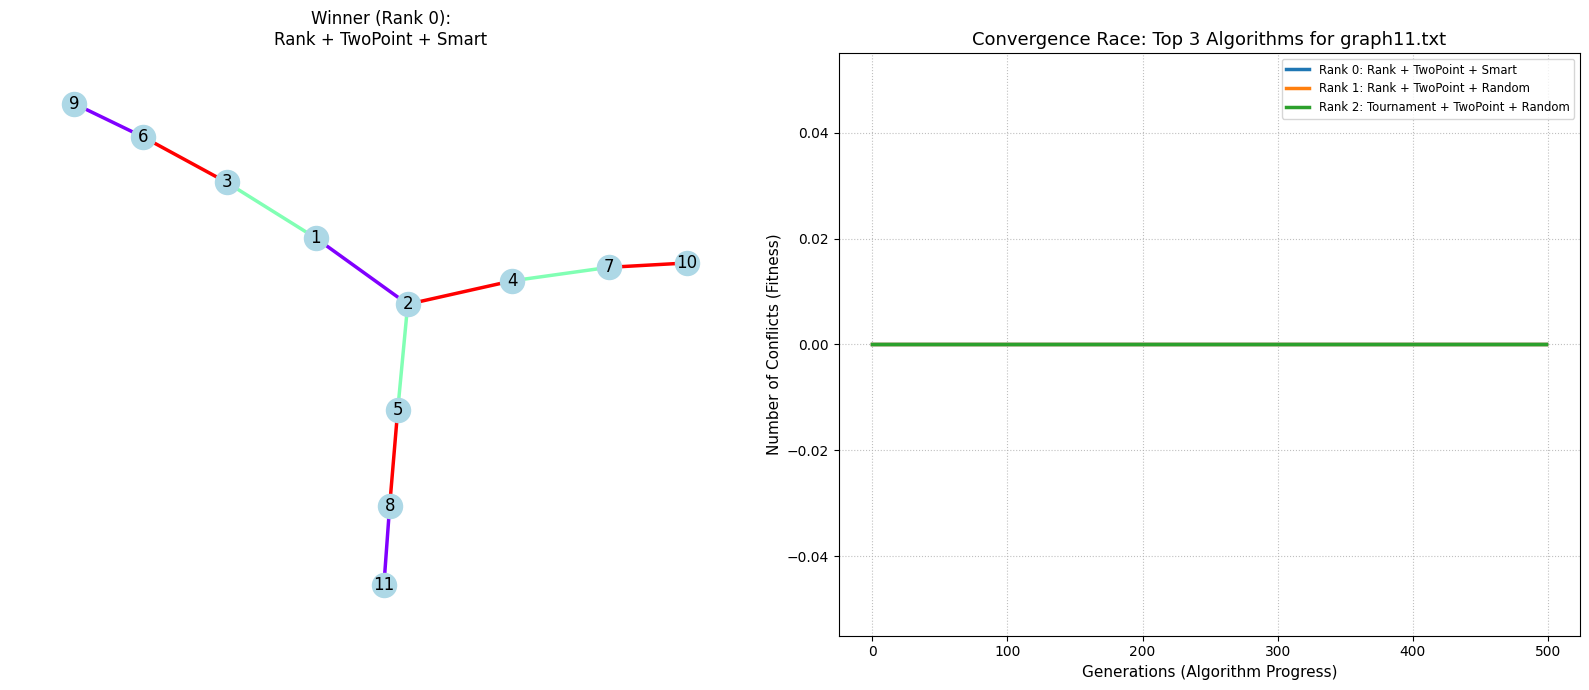

Full table saved to: resultsGA/graph11.txt

>>> ANALYZING: graph13.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph13.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ TwoPoint    │ Smart      │             0 │         9 │ 0.052776 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Tournament  │ SinglePoint │ Swap       │             0 │         9 │ 0.059556 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Swap       │             0 │         9 │ 0.063989 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


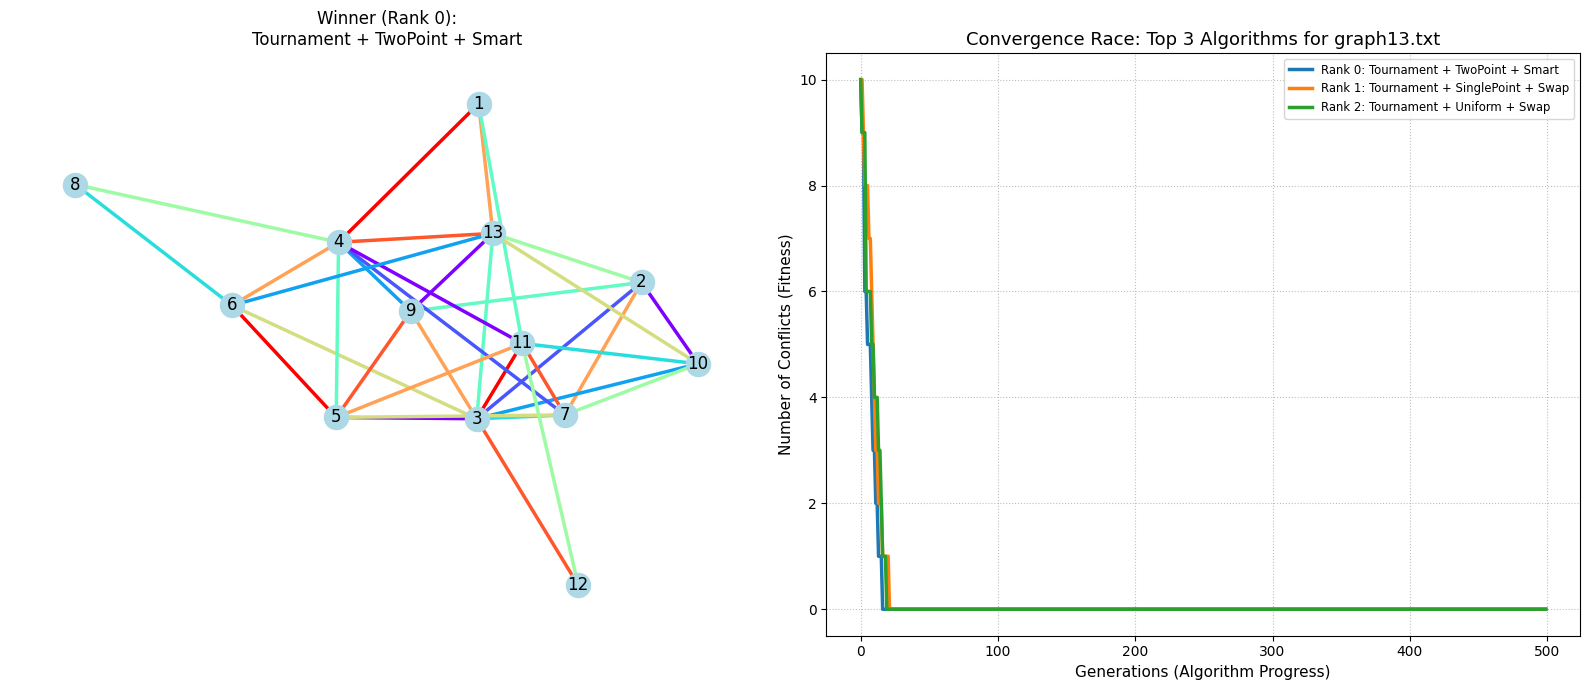

Full table saved to: resultsGA/graph13.txt

>>> ANALYZING: graph15.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph15.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ SinglePoint │ Random     │             0 │         6 │ 0.036314 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Tournament  │ TwoPoint    │ Smart      │             0 │         6 │ 0.036417 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Random     │             0 │         6 │ 0.040585 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


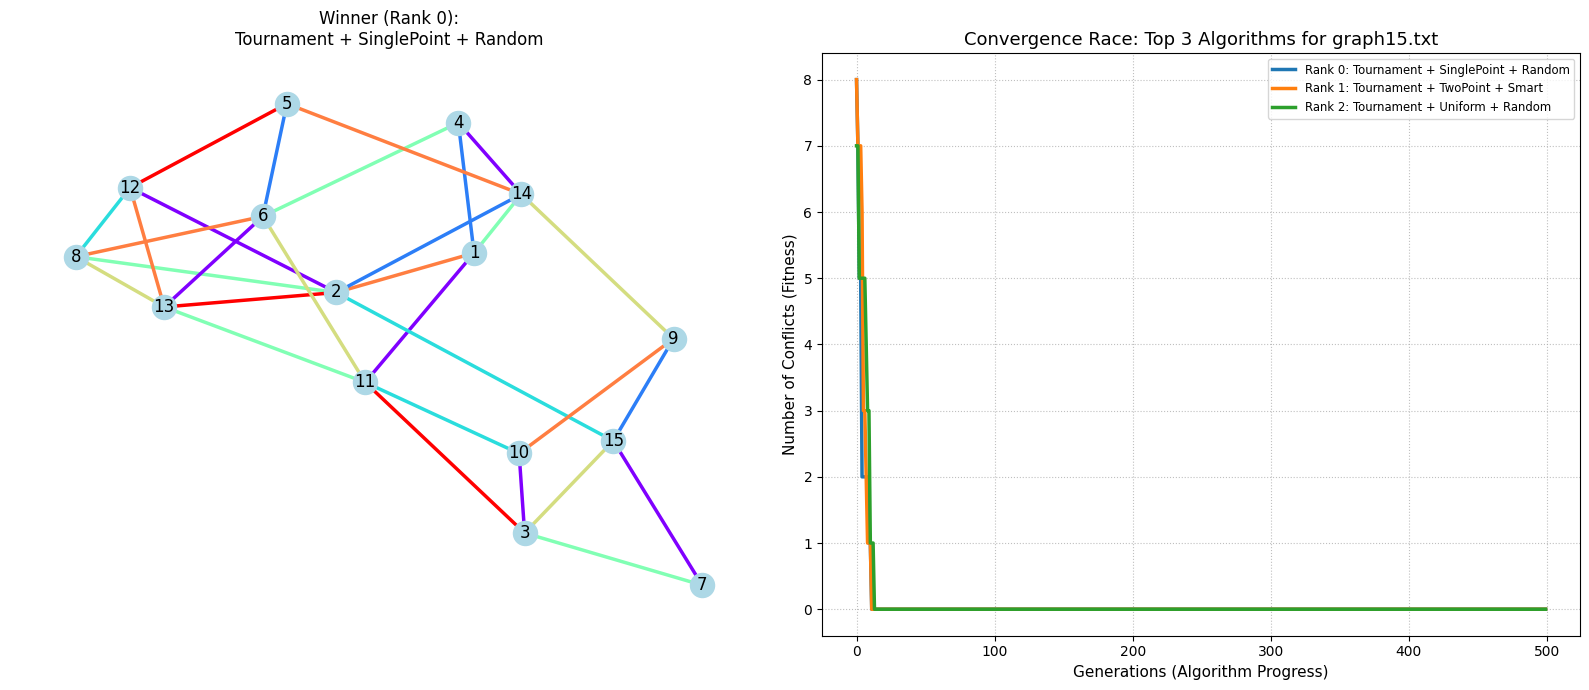

Full table saved to: resultsGA/graph15.txt

>>> ANALYZING: graph5.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph5.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │         3 │ 0.000959 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Tournament  │ Uniform     │ Random     │             0 │         3 │ 0.000963 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Smart      │             0 │         3 │ 0.000988 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


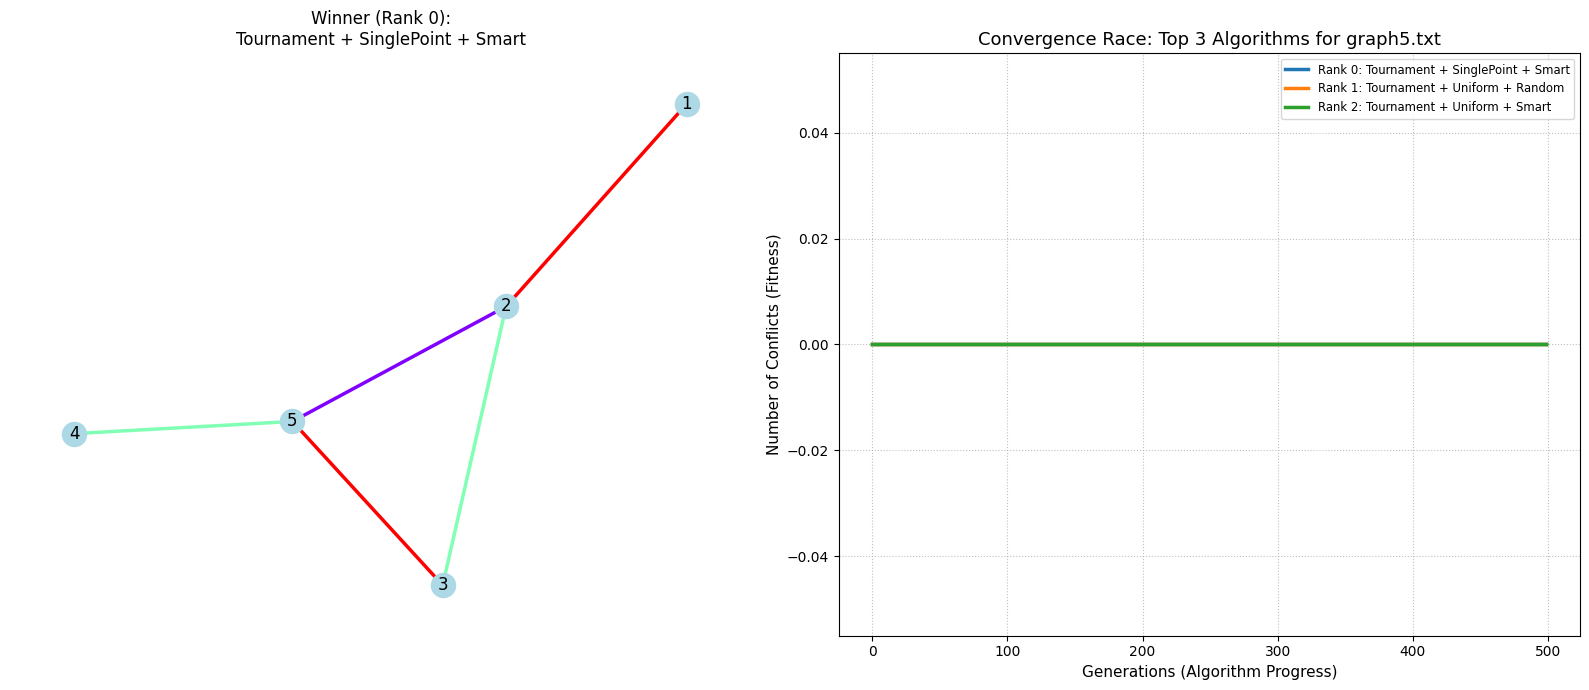

Full table saved to: resultsGA/graph5.txt

>>> ANALYZING: graph6.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph6.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Rank        │ SinglePoint │ Smart      │             0 │         3 │ 0.001906 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Roulette    │ Uniform     │ Smart      │             0 │         3 │ 0.003855 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ TwoPoint    │ Swap       │             0 │         3 │ 0.003872 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


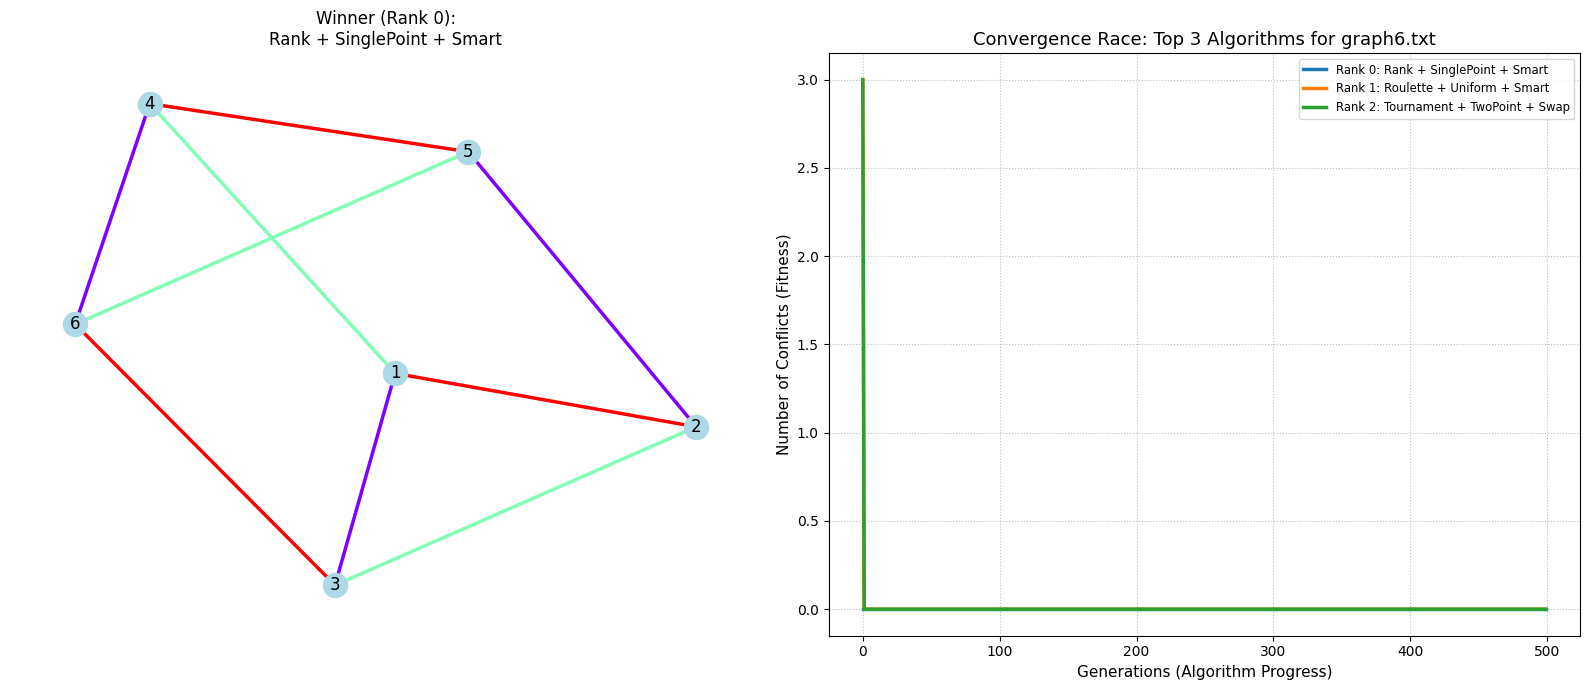

Full table saved to: resultsGA/graph6.txt

>>> ANALYZING: graph9.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph9.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │         3 │ 0.001343 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Rank        │ TwoPoint    │ Random     │             0 │         3 │ 0.001352 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Rank        │ SinglePoint │ Swap       │             0 │         3 │ 0.001382 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


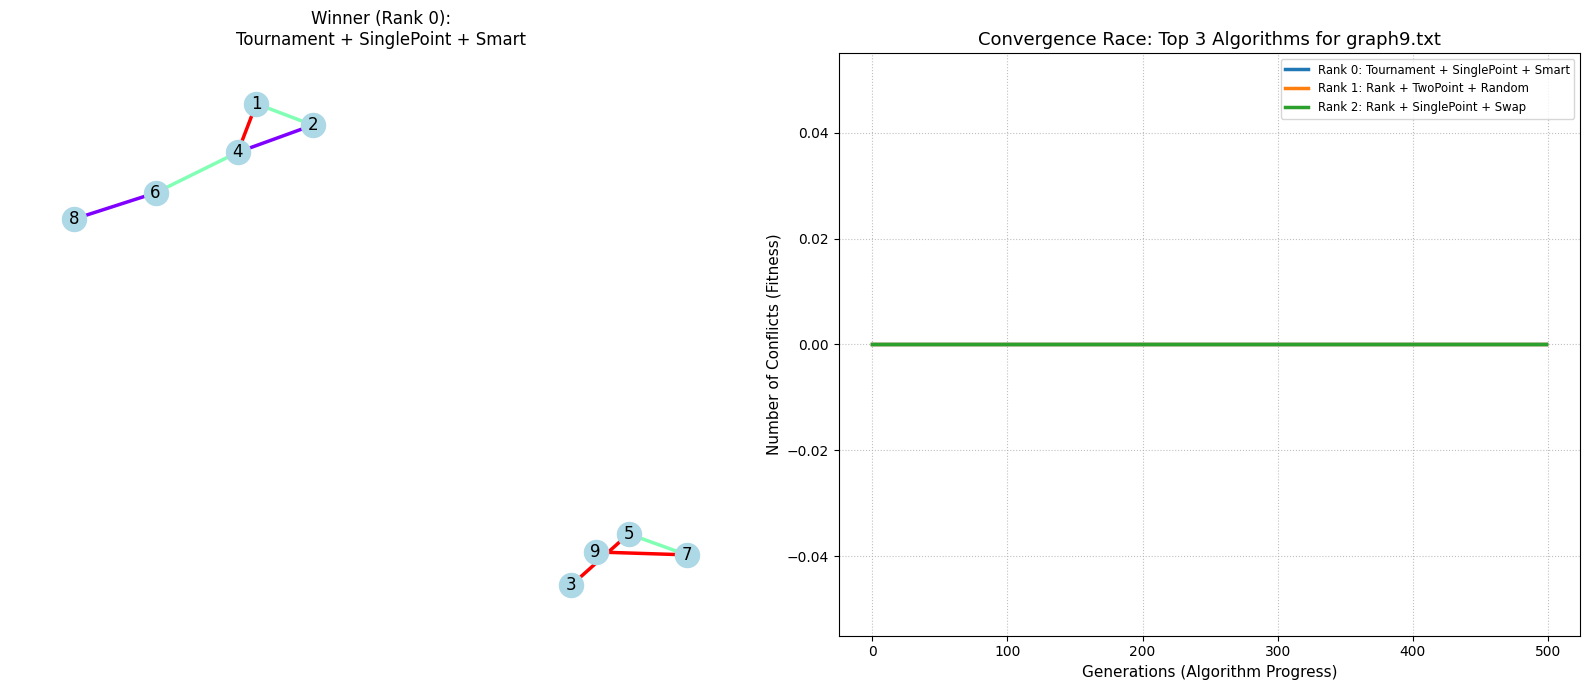

Full table saved to: resultsGA/graph9.txt

########################################
# ENTERING FOLDER: bigTests
########################################

>>> ANALYZING: big22.txt
[TYPE]: Unknown Graph Type
Top 3 Combinations for big22.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │        17 │ 0.298039 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Tournament  │ Uniform     │ Smart      │             0 │        17 │ 0.369873 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ TwoPoint    │ Smart      │             0 │        17 │ 0.379321 │
╘════════╧═════════════╧════════

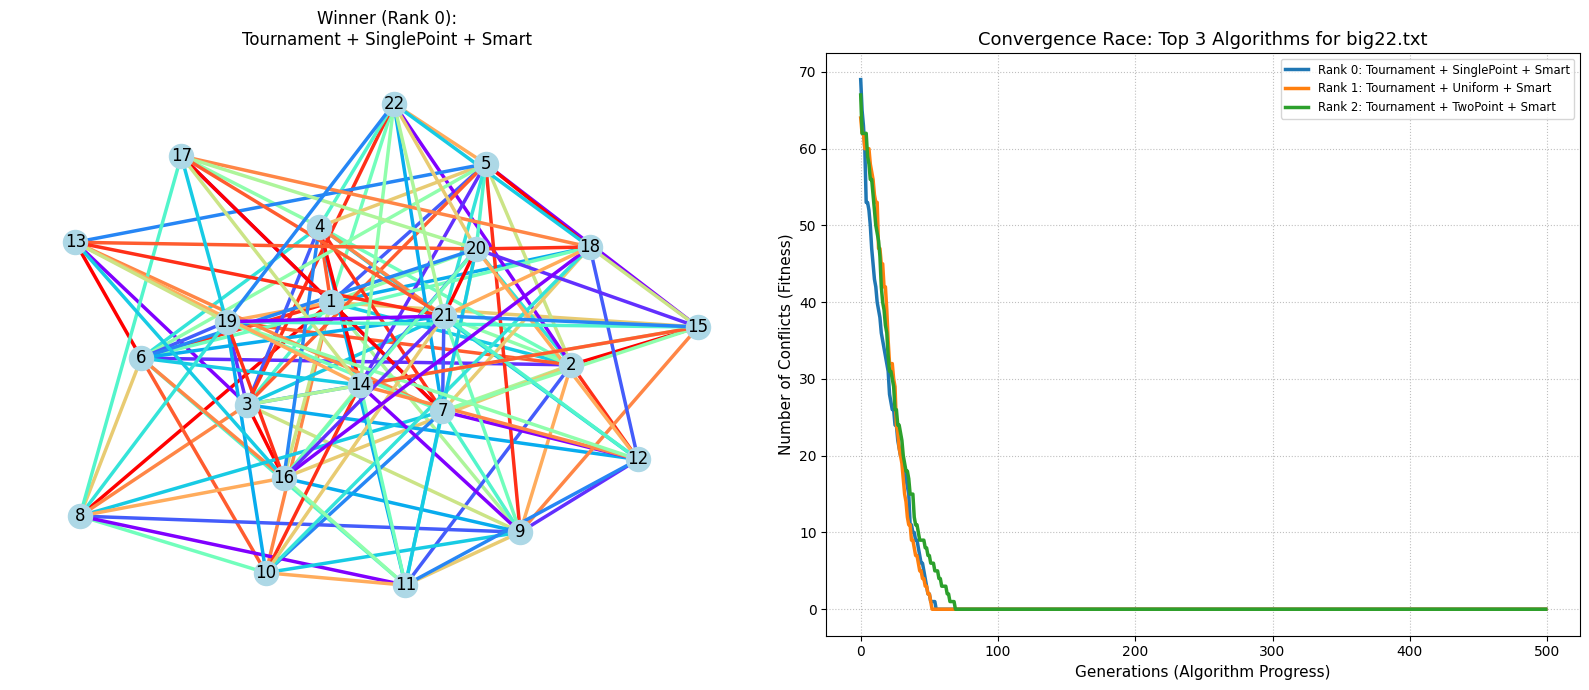

Full table saved to: resultsGA/big22.txt

>>> ANALYZING: big30.txt
[TYPE]: Unknown Graph Type
Top 3 Combinations for big30.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │        23 │ 1.19784 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Rank        │ TwoPoint    │ Smart      │             0 │        23 │ 2.71642 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Rank        │ Uniform     │ Smart      │             0 │        23 │ 2.83495 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧═════════╛


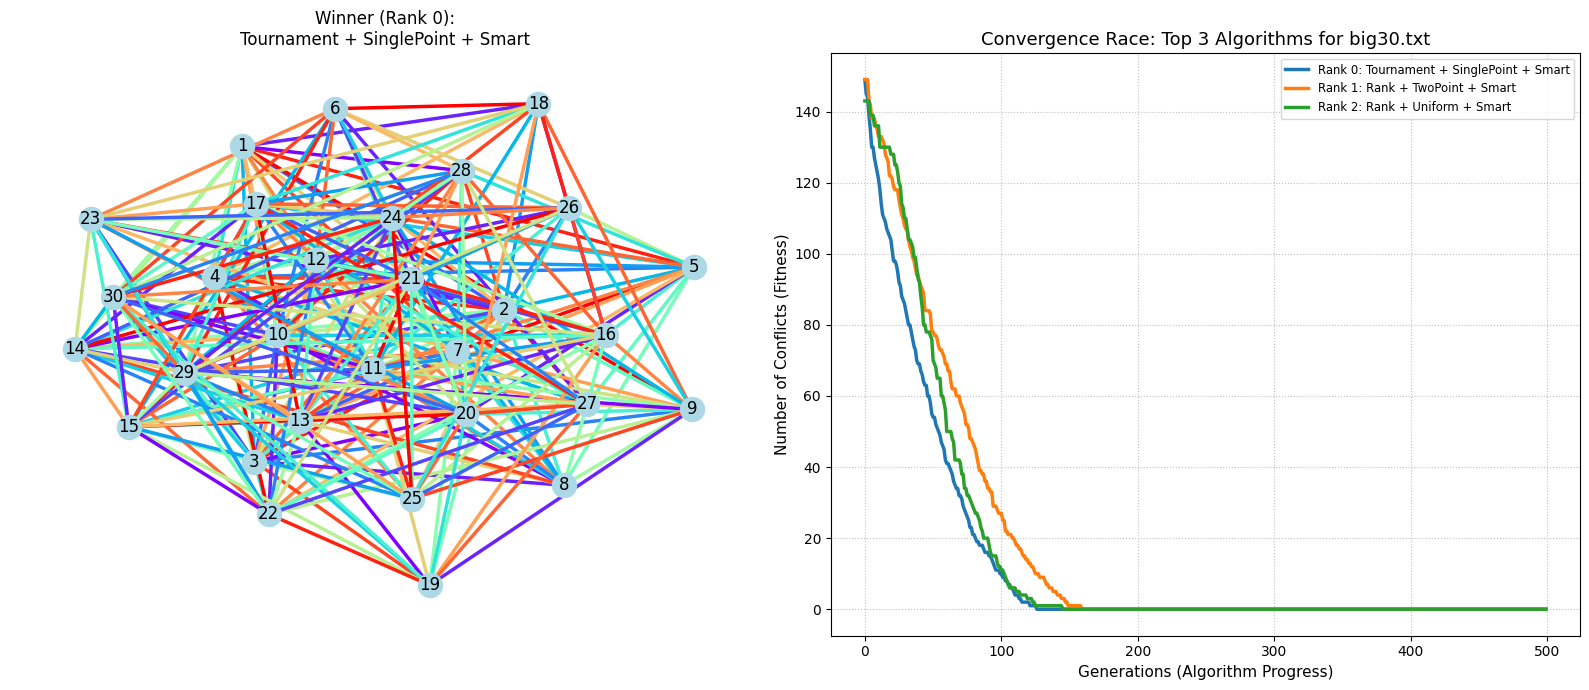

Full table saved to: resultsGA/big30.txt

>>> ANALYZING: big47.6.txt
[TYPE]: Unknown Graph Type
Top 3 Combinations for big47.6.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │        23 │ 0.59593  │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Tournament  │ TwoPoint    │ Smart      │             0 │        23 │ 0.63149  │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Smart      │             0 │        23 │ 0.975327 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


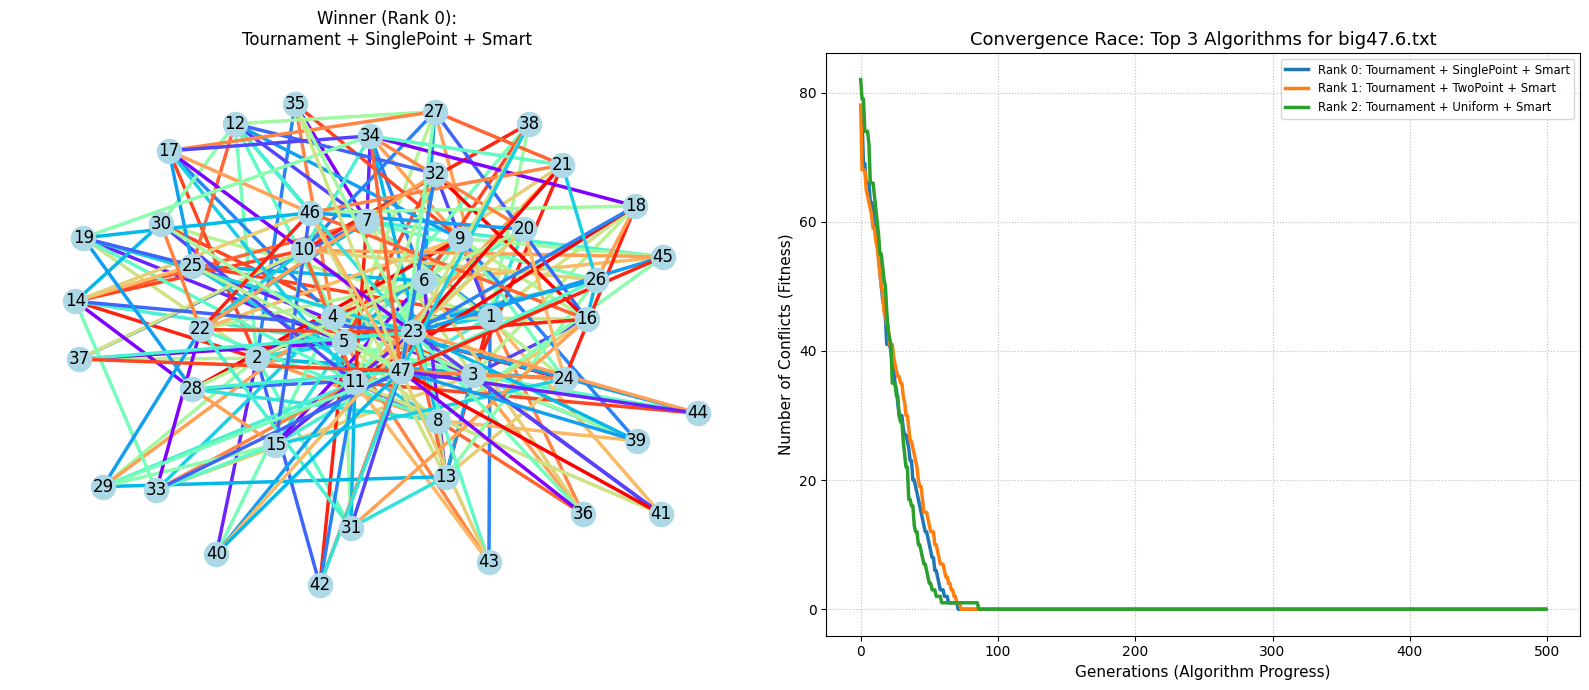

Full table saved to: resultsGA/big47.6.txt

>>> ANALYZING: big95.txt
[TYPE]: Unknown Graph Type
Top 3 Combinations for big95.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ TwoPoint    │ Smart      │             0 │        47 │ 4.99895 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ Uniform     │ Smart      │             0 │        47 │ 5.6253  │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Smart      │             0 │        47 │ 5.95667 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧═════════╛


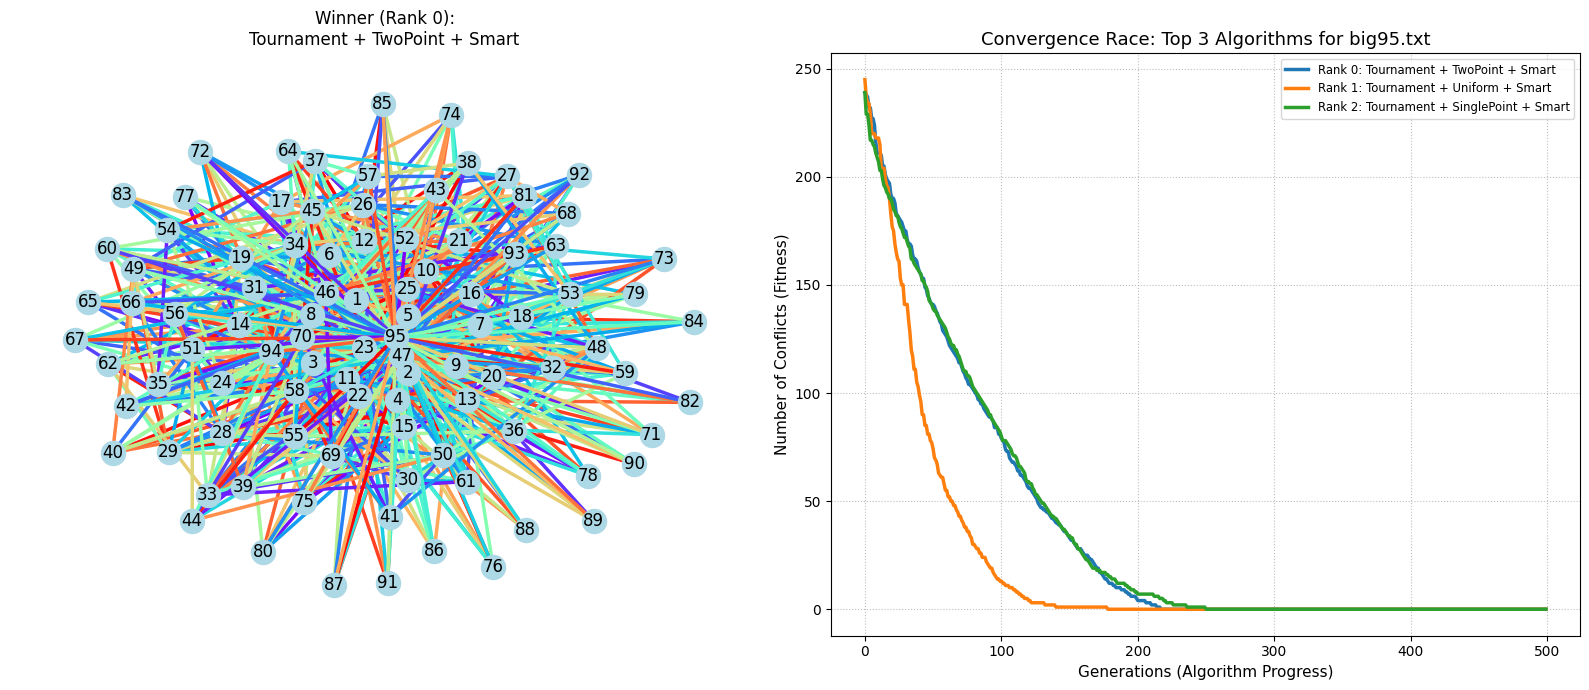

Full table saved to: resultsGA/big95.txt


In [8]:
#Novo ucitavanje fajla

targetFolders = ['smallTests','bigTests']

for folder in targetFolders:
    #kreiramo putanju za pretragu
    searchPath = os.path.join('tests',folder,"*.txt")
    allFiles = sorted(glob.glob(searchPath))

    if not allFiles:
        print(f"No files found in: tests/{folder}")
        continue

    print(f"\n{'#'*40}\n# ENTERING FOLDER: {folder}\n{'#'*40}")

    for f in allFiles:
        #fileName = os.path.basename(f)
        processAndVisualize(f)